In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
data = np.loadtxt('.\\data\\binned_configurations_array.csv', delimiter=',')

In [4]:
X = data[:, :-1]
T = data[:, -1]

In [5]:
X.shape  # 41 temperatures, 100 samples each. 12x12 lattice with 144 sites.

(4100, 144)

In [6]:
T.shape   # Single label (temperature) for each sample

(4100,)

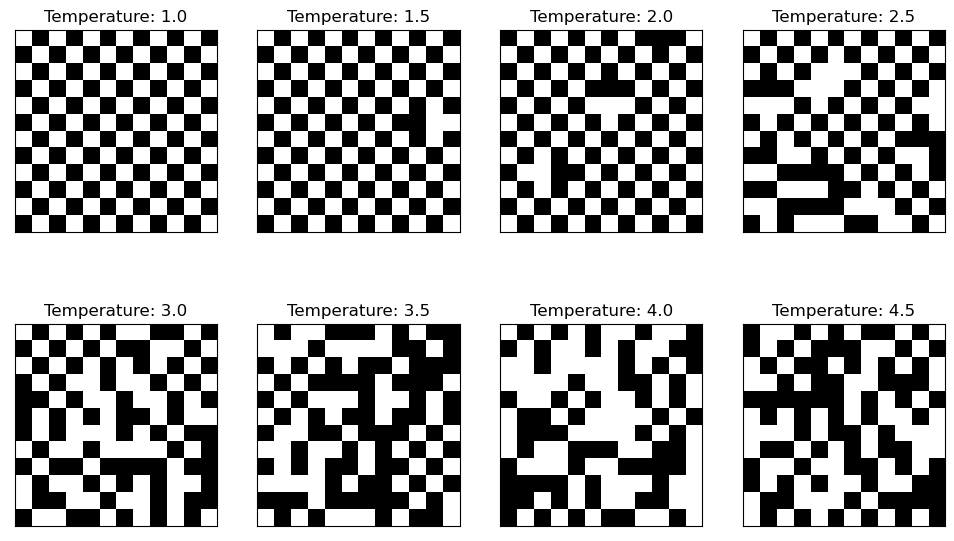

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7))
index = 0

for i in range(2):
    for j in range(4):

        axs[i, j].imshow(X[index*500].reshape(12, 12), cmap="binary", origin='lower')
        #axs[i, j].set_xticks(list(range(12)))
        #axs[i, j].set_yticks(list(range(12)))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(f'Temperature: {T[index*500]}')
        #axs[i, j].axis('off')
        index += 1

In [9]:
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, T_train, T_val = train_test_split(X_train, T_train, test_size=0.25, random_state=1, shuffle=True)

y_train = (T_train < 2.269).astype(int)
y_test = (T_test < 2.269).astype(int)
y_val = (T_val < 2.269).astype(int)

In [10]:
X_train.shape

(2460, 144)

In [11]:
y_train.shape

(2460,)

In [12]:
X_test.shape

(820, 144)

In [13]:
y_test.shape

(820,)

In [14]:
X_val.shape

(820, 144)

In [15]:
y_val.shape

(820,)

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [17]:
X_train

tensor([[ 1., -1.,  1.,  ...,  1., -1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1., -1.],
        [ 1., -1.,  1.,  ..., -1.,  1., -1.],
        ...,
        [-1.,  1., -1.,  ...,  1., -1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        [-1.,  1., -1.,  ...,  1.,  1., -1.]])

In [18]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [19]:
next(iter(train_dl))

[tensor([[-1.,  1., -1.,  ..., -1.,  1., -1.],
         [-1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
         ...,
         [ 1.,  1., -1.,  ...,  1., -1.,  1.],
         [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
         [ 1.,  1., -1.,  ...,  1.,  1., -1.]]),
 tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])]

In [20]:
model = nn.Sequential(

    nn.Linear(144, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, 10),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(10, 1),
    nn.Sigmoid()
    
)

In [21]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
num_epochs = 20

In [22]:
torch.manual_seed(1)

In [23]:
def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):

        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)[:, 0]
                        
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:

                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch + 1}    Train Accuracy: {accuracy_hist_train[epoch]:.4f}   Train Loss: {loss_hist_train[epoch]:.4f}     Valid Accuracy: {accuracy_hist_valid[epoch]:.4f}   Valid Loss: {loss_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

In [25]:
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1    Train Accuracy: 0.6833   Train Loss: 0.6248     Valid Accuracy: 0.7049   Valid Loss: 0.6137
Epoch 2    Train Accuracy: 0.6785   Train Loss: 0.6150     Valid Accuracy: 0.7049   Valid Loss: 0.5945
Epoch 3    Train Accuracy: 0.6785   Train Loss: 0.5798     Valid Accuracy: 0.7049   Valid Loss: 0.5376
Epoch 4    Train Accuracy: 0.8000   Train Loss: 0.4842     Valid Accuracy: 0.9610   Valid Loss: 0.3974
Epoch 5    Train Accuracy: 0.9516   Train Loss: 0.3361     Valid Accuracy: 0.9561   Valid Loss: 0.2906
Epoch 6    Train Accuracy: 0.9492   Train Loss: 0.2756     Valid Accuracy: 0.9512   Valid Loss: 0.2688
Epoch 7    Train Accuracy: 0.9516   Train Loss: 0.2624     Valid Accuracy: 0.9512   Valid Loss: 0.2526
Epoch 8    Train Accuracy: 0.9533   Train Loss: 0.2530     Valid Accuracy: 0.9524   Valid Loss: 0.2498
Epoch 9    Train Accuracy: 0.9512   Train Loss: 0.2460     Valid Accuracy: 0.9537   Valid Loss: 0.2581
Epoch 10    Train Accuracy: 0.9520   Train Loss: 0.2494     Valid Accurac

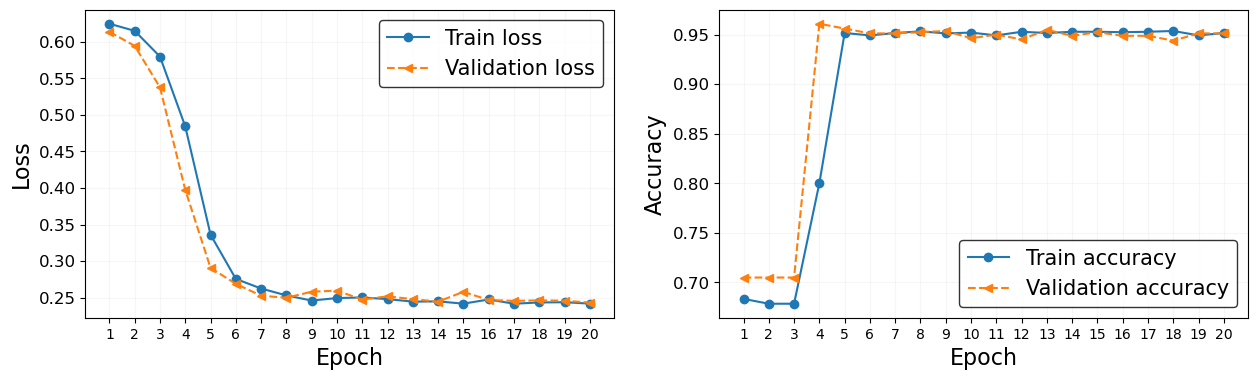

In [26]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[2], '--<', label='Validation loss')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Loss', size=16)
ax.set_xticks(np.arange(20)+1)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=12)
ax.grid(alpha=0.1)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[1], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<', label='Validation accuracy')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=16)
ax.set_ylabel('Accuracy', size=16)
ax.set_xticks(np.arange(20)+1)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=12)
ax.grid(alpha=0.1)

plt.show()

In [27]:
pred = model(X_test)[:, 0]
is_correct = ((pred >= 0.5).float() == y_test).int()
test_accuracy = (is_correct.sum() / is_correct.shape[0]).item()
print(f'Test set accuracy = {test_accuracy}')

Test set accuracy = 0.962195098400116


In [28]:
unit_vals = [(128, 32), (64, 32), (32, 16), (32, 10), (16, 8)]
weight_decay_vals = [0, 0.001, 0.01, 0.1]
dropout_vals = [0, 0.1, 0.2, 0.5]
lr = 0.001

tuning_results_lr0p001 = np.empty(shape=(5,4,4), dtype=object)

u = 0

for unit in unit_vals:
    
    w = 0

    for weight_decay in weight_decay_vals:

        d = 0

        for dropout in dropout_vals:

            print('\n')
            print(f'units = {unit}, weight decay = {weight_decay}, dropout = {dropout}:  \n')

            hd1 = unit[0]
            hd2 = unit[1]
            lr = lr

            model = nn.Sequential(
                        
                        nn.Linear(144, hd1),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(hd1, hd2),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(hd2, 1),
                        nn.Sigmoid())

            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
            num_epochs = 30

            params = (unit, weight_decay, dropout)
            hist = train(model, num_epochs, train_dl, valid_dl)

            tuning_results_lr0p001[u, w, d] = [params, hist]

            d += 1

        w += 1
        
    u += 1



units = (128, 32), weight decay = 0, dropout = 0:  

Epoch 1    Train Accuracy: 0.9366   Train Loss: 0.3496     Valid Accuracy: 0.9622   Valid Loss: 0.1238
Epoch 2    Train Accuracy: 0.9667   Train Loss: 0.0995     Valid Accuracy: 0.9622   Valid Loss: 0.0902
Epoch 3    Train Accuracy: 0.9740   Train Loss: 0.0802     Valid Accuracy: 0.9683   Valid Loss: 0.0845
Epoch 4    Train Accuracy: 0.9772   Train Loss: 0.0637     Valid Accuracy: 0.9634   Valid Loss: 0.0831
Epoch 5    Train Accuracy: 0.9797   Train Loss: 0.0523     Valid Accuracy: 0.9671   Valid Loss: 0.0894
Epoch 6    Train Accuracy: 0.9833   Train Loss: 0.0461     Valid Accuracy: 0.9561   Valid Loss: 0.1119
Epoch 7    Train Accuracy: 0.9902   Train Loss: 0.0321     Valid Accuracy: 0.9659   Valid Loss: 0.1009
Epoch 8    Train Accuracy: 0.9894   Train Loss: 0.0320     Valid Accuracy: 0.9622   Valid Loss: 0.1000
Epoch 9    Train Accuracy: 0.9890   Train Loss: 0.0289     Valid Accuracy: 0.9671   Valid Loss: 0.1023
Epoch 10    Train 

Epoch 19    Train Accuracy: 1.0000   Train Loss: 0.0019     Valid Accuracy: 0.9634   Valid Loss: 0.1562
Epoch 20    Train Accuracy: 1.0000   Train Loss: 0.0018     Valid Accuracy: 0.9598   Valid Loss: 0.1556
Epoch 21    Train Accuracy: 1.0000   Train Loss: 0.0008     Valid Accuracy: 0.9610   Valid Loss: 0.1585
Epoch 22    Train Accuracy: 1.0000   Train Loss: 0.0006     Valid Accuracy: 0.9610   Valid Loss: 0.1609
Epoch 23    Train Accuracy: 1.0000   Train Loss: 0.0005     Valid Accuracy: 0.9622   Valid Loss: 0.1622
Epoch 24    Train Accuracy: 1.0000   Train Loss: 0.0005     Valid Accuracy: 0.9622   Valid Loss: 0.1643
Epoch 25    Train Accuracy: 1.0000   Train Loss: 0.0004     Valid Accuracy: 0.9610   Valid Loss: 0.1657
Epoch 26    Train Accuracy: 1.0000   Train Loss: 0.0004     Valid Accuracy: 0.9610   Valid Loss: 0.1689
Epoch 27    Train Accuracy: 1.0000   Train Loss: 0.0004     Valid Accuracy: 0.9610   Valid Loss: 0.1702
Epoch 28    Train Accuracy: 1.0000   Train Loss: 0.0003     Vali

Epoch 7    Train Accuracy: 0.9902   Train Loss: 0.0331     Valid Accuracy: 0.9646   Valid Loss: 0.0990
Epoch 8    Train Accuracy: 0.9911   Train Loss: 0.0330     Valid Accuracy: 0.9610   Valid Loss: 0.1153
Epoch 9    Train Accuracy: 0.9854   Train Loss: 0.0349     Valid Accuracy: 0.9622   Valid Loss: 0.0973
Epoch 10    Train Accuracy: 0.9943   Train Loss: 0.0225     Valid Accuracy: 0.9610   Valid Loss: 0.1024
Epoch 11    Train Accuracy: 0.9959   Train Loss: 0.0172     Valid Accuracy: 0.9659   Valid Loss: 0.1035
Epoch 12    Train Accuracy: 0.9972   Train Loss: 0.0145     Valid Accuracy: 0.9598   Valid Loss: 0.1175
Epoch 13    Train Accuracy: 0.9963   Train Loss: 0.0146     Valid Accuracy: 0.9561   Valid Loss: 0.1291
Epoch 14    Train Accuracy: 0.9967   Train Loss: 0.0130     Valid Accuracy: 0.9646   Valid Loss: 0.1144
Epoch 15    Train Accuracy: 0.9984   Train Loss: 0.0094     Valid Accuracy: 0.9561   Valid Loss: 0.1353
Epoch 16    Train Accuracy: 0.9988   Train Loss: 0.0072     Valid A

Epoch 25    Train Accuracy: 1.0000   Train Loss: 0.0031     Valid Accuracy: 0.9622   Valid Loss: 0.1179
Epoch 26    Train Accuracy: 1.0000   Train Loss: 0.0029     Valid Accuracy: 0.9634   Valid Loss: 0.1123
Epoch 27    Train Accuracy: 1.0000   Train Loss: 0.0029     Valid Accuracy: 0.9622   Valid Loss: 0.1126
Epoch 28    Train Accuracy: 1.0000   Train Loss: 0.0038     Valid Accuracy: 0.9610   Valid Loss: 0.1148
Epoch 29    Train Accuracy: 1.0000   Train Loss: 0.0035     Valid Accuracy: 0.9598   Valid Loss: 0.1131
Epoch 30    Train Accuracy: 1.0000   Train Loss: 0.0031     Valid Accuracy: 0.9634   Valid Loss: 0.1152


units = (128, 32), weight decay = 0.01, dropout = 0:  

Epoch 1    Train Accuracy: 0.9415   Train Loss: 0.3322     Valid Accuracy: 0.9585   Valid Loss: 0.1366
Epoch 2    Train Accuracy: 0.9622   Train Loss: 0.1211     Valid Accuracy: 0.9634   Valid Loss: 0.1103
Epoch 3    Train Accuracy: 0.9691   Train Loss: 0.1044     Valid Accuracy: 0.9622   Valid Loss: 0.1042
Epoch 4  

Epoch 13    Train Accuracy: 0.9898   Train Loss: 0.0471     Valid Accuracy: 0.9549   Valid Loss: 0.1264
Epoch 14    Train Accuracy: 0.9902   Train Loss: 0.0467     Valid Accuracy: 0.9500   Valid Loss: 0.1094
Epoch 15    Train Accuracy: 0.9833   Train Loss: 0.0603     Valid Accuracy: 0.9500   Valid Loss: 0.1224
Epoch 16    Train Accuracy: 0.9878   Train Loss: 0.0469     Valid Accuracy: 0.9573   Valid Loss: 0.0998
Epoch 17    Train Accuracy: 0.9902   Train Loss: 0.0403     Valid Accuracy: 0.9549   Valid Loss: 0.1075
Epoch 18    Train Accuracy: 0.9923   Train Loss: 0.0399     Valid Accuracy: 0.9549   Valid Loss: 0.1045
Epoch 19    Train Accuracy: 0.9894   Train Loss: 0.0449     Valid Accuracy: 0.9585   Valid Loss: 0.1050
Epoch 20    Train Accuracy: 0.9911   Train Loss: 0.0387     Valid Accuracy: 0.9537   Valid Loss: 0.1079
Epoch 21    Train Accuracy: 0.9858   Train Loss: 0.0511     Valid Accuracy: 0.9707   Valid Loss: 0.1041
Epoch 22    Train Accuracy: 0.9943   Train Loss: 0.0351     Vali

Epoch 1    Train Accuracy: 0.8593   Train Loss: 0.5899     Valid Accuracy: 0.9439   Valid Loss: 0.5156
Epoch 2    Train Accuracy: 0.9350   Train Loss: 0.4262     Valid Accuracy: 0.9415   Valid Loss: 0.3295
Epoch 3    Train Accuracy: 0.9472   Train Loss: 0.2941     Valid Accuracy: 0.9512   Valid Loss: 0.2690
Epoch 4    Train Accuracy: 0.9533   Train Loss: 0.2603     Valid Accuracy: 0.9476   Valid Loss: 0.2748
Epoch 5    Train Accuracy: 0.9549   Train Loss: 0.2569     Valid Accuracy: 0.9390   Valid Loss: 0.2577
Epoch 6    Train Accuracy: 0.9492   Train Loss: 0.2491     Valid Accuracy: 0.9488   Valid Loss: 0.2517
Epoch 7    Train Accuracy: 0.9500   Train Loss: 0.2473     Valid Accuracy: 0.9573   Valid Loss: 0.2478
Epoch 8    Train Accuracy: 0.9500   Train Loss: 0.2481     Valid Accuracy: 0.9537   Valid Loss: 0.2503
Epoch 9    Train Accuracy: 0.9488   Train Loss: 0.2468     Valid Accuracy: 0.9463   Valid Loss: 0.2418
Epoch 10    Train Accuracy: 0.9528   Train Loss: 0.2497     Valid Accurac

Epoch 19    Train Accuracy: 0.9496   Train Loss: 0.2479     Valid Accuracy: 0.9524   Valid Loss: 0.2464
Epoch 20    Train Accuracy: 0.9524   Train Loss: 0.2505     Valid Accuracy: 0.9524   Valid Loss: 0.2464
Epoch 21    Train Accuracy: 0.9508   Train Loss: 0.2479     Valid Accuracy: 0.9524   Valid Loss: 0.2448
Epoch 22    Train Accuracy: 0.9524   Train Loss: 0.2468     Valid Accuracy: 0.9537   Valid Loss: 0.2463
Epoch 23    Train Accuracy: 0.9516   Train Loss: 0.2448     Valid Accuracy: 0.9451   Valid Loss: 0.2502
Epoch 24    Train Accuracy: 0.9537   Train Loss: 0.2451     Valid Accuracy: 0.9524   Valid Loss: 0.2482
Epoch 25    Train Accuracy: 0.9496   Train Loss: 0.2458     Valid Accuracy: 0.9402   Valid Loss: 0.2535
Epoch 26    Train Accuracy: 0.9508   Train Loss: 0.2507     Valid Accuracy: 0.9366   Valid Loss: 0.2516
Epoch 27    Train Accuracy: 0.9541   Train Loss: 0.2435     Valid Accuracy: 0.9537   Valid Loss: 0.2466
Epoch 28    Train Accuracy: 0.9516   Train Loss: 0.2455     Vali

Epoch 7    Train Accuracy: 0.9801   Train Loss: 0.0521     Valid Accuracy: 0.9646   Valid Loss: 0.0998
Epoch 8    Train Accuracy: 0.9837   Train Loss: 0.0520     Valid Accuracy: 0.9561   Valid Loss: 0.1241
Epoch 9    Train Accuracy: 0.9902   Train Loss: 0.0408     Valid Accuracy: 0.9634   Valid Loss: 0.1015
Epoch 10    Train Accuracy: 0.9878   Train Loss: 0.0342     Valid Accuracy: 0.9671   Valid Loss: 0.1011
Epoch 11    Train Accuracy: 0.9898   Train Loss: 0.0311     Valid Accuracy: 0.9561   Valid Loss: 0.1305
Epoch 12    Train Accuracy: 0.9939   Train Loss: 0.0222     Valid Accuracy: 0.9659   Valid Loss: 0.1054
Epoch 13    Train Accuracy: 0.9939   Train Loss: 0.0221     Valid Accuracy: 0.9622   Valid Loss: 0.1188
Epoch 14    Train Accuracy: 0.9947   Train Loss: 0.0187     Valid Accuracy: 0.9622   Valid Loss: 0.1231
Epoch 15    Train Accuracy: 0.9959   Train Loss: 0.0144     Valid Accuracy: 0.9622   Valid Loss: 0.1245
Epoch 16    Train Accuracy: 0.9967   Train Loss: 0.0115     Valid A

Epoch 25    Train Accuracy: 1.0000   Train Loss: 0.0037     Valid Accuracy: 0.9683   Valid Loss: 0.1127
Epoch 26    Train Accuracy: 1.0000   Train Loss: 0.0034     Valid Accuracy: 0.9622   Valid Loss: 0.1188
Epoch 27    Train Accuracy: 1.0000   Train Loss: 0.0042     Valid Accuracy: 0.9634   Valid Loss: 0.1191
Epoch 28    Train Accuracy: 1.0000   Train Loss: 0.0060     Valid Accuracy: 0.9610   Valid Loss: 0.1282
Epoch 29    Train Accuracy: 0.9996   Train Loss: 0.0067     Valid Accuracy: 0.9622   Valid Loss: 0.1214
Epoch 30    Train Accuracy: 0.9992   Train Loss: 0.0078     Valid Accuracy: 0.9598   Valid Loss: 0.1204


units = (64, 32), weight decay = 0.001, dropout = 0.1:  

Epoch 1    Train Accuracy: 0.8951   Train Loss: 0.4134     Valid Accuracy: 0.9512   Valid Loss: 0.1690
Epoch 2    Train Accuracy: 0.9614   Train Loss: 0.1170     Valid Accuracy: 0.9622   Valid Loss: 0.0983
Epoch 3    Train Accuracy: 0.9695   Train Loss: 0.0854     Valid Accuracy: 0.9598   Valid Loss: 0.0969
Epoch 4

Epoch 13    Train Accuracy: 0.9951   Train Loss: 0.0191     Valid Accuracy: 0.9659   Valid Loss: 0.1084
Epoch 14    Train Accuracy: 0.9976   Train Loss: 0.0153     Valid Accuracy: 0.9695   Valid Loss: 0.0995
Epoch 15    Train Accuracy: 0.9972   Train Loss: 0.0123     Valid Accuracy: 0.9598   Valid Loss: 0.1171
Epoch 16    Train Accuracy: 0.9976   Train Loss: 0.0128     Valid Accuracy: 0.9610   Valid Loss: 0.1095
Epoch 17    Train Accuracy: 0.9988   Train Loss: 0.0090     Valid Accuracy: 0.9659   Valid Loss: 0.1033
Epoch 18    Train Accuracy: 0.9992   Train Loss: 0.0072     Valid Accuracy: 0.9610   Valid Loss: 0.1074
Epoch 19    Train Accuracy: 0.9996   Train Loss: 0.0061     Valid Accuracy: 0.9634   Valid Loss: 0.1095
Epoch 20    Train Accuracy: 0.9980   Train Loss: 0.0109     Valid Accuracy: 0.9500   Valid Loss: 0.1718
Epoch 21    Train Accuracy: 0.9959   Train Loss: 0.0139     Valid Accuracy: 0.9610   Valid Loss: 0.1197
Epoch 22    Train Accuracy: 1.0000   Train Loss: 0.0054     Vali

Epoch 1    Train Accuracy: 0.9163   Train Loss: 0.4336     Valid Accuracy: 0.9573   Valid Loss: 0.1900
Epoch 2    Train Accuracy: 0.9565   Train Loss: 0.1408     Valid Accuracy: 0.9610   Valid Loss: 0.1213
Epoch 3    Train Accuracy: 0.9630   Train Loss: 0.1110     Valid Accuracy: 0.9537   Valid Loss: 0.1158
Epoch 4    Train Accuracy: 0.9736   Train Loss: 0.0934     Valid Accuracy: 0.9610   Valid Loss: 0.1010
Epoch 5    Train Accuracy: 0.9724   Train Loss: 0.0805     Valid Accuracy: 0.9585   Valid Loss: 0.1123
Epoch 6    Train Accuracy: 0.9768   Train Loss: 0.0779     Valid Accuracy: 0.9585   Valid Loss: 0.0995
Epoch 7    Train Accuracy: 0.9789   Train Loss: 0.0687     Valid Accuracy: 0.9622   Valid Loss: 0.1055
Epoch 8    Train Accuracy: 0.9805   Train Loss: 0.0708     Valid Accuracy: 0.9659   Valid Loss: 0.1001
Epoch 9    Train Accuracy: 0.9821   Train Loss: 0.0626     Valid Accuracy: 0.9634   Valid Loss: 0.0947
Epoch 10    Train Accuracy: 0.9882   Train Loss: 0.0554     Valid Accurac

Epoch 20    Train Accuracy: 0.9520   Train Loss: 0.2416     Valid Accuracy: 0.9524   Valid Loss: 0.2405
Epoch 21    Train Accuracy: 0.9545   Train Loss: 0.2391     Valid Accuracy: 0.9402   Valid Loss: 0.2565
Epoch 22    Train Accuracy: 0.9504   Train Loss: 0.2425     Valid Accuracy: 0.9537   Valid Loss: 0.2428
Epoch 23    Train Accuracy: 0.9528   Train Loss: 0.2393     Valid Accuracy: 0.9524   Valid Loss: 0.2472
Epoch 24    Train Accuracy: 0.9537   Train Loss: 0.2394     Valid Accuracy: 0.9524   Valid Loss: 0.2440
Epoch 25    Train Accuracy: 0.9541   Train Loss: 0.2433     Valid Accuracy: 0.9463   Valid Loss: 0.2508
Epoch 26    Train Accuracy: 0.9508   Train Loss: 0.2439     Valid Accuracy: 0.9512   Valid Loss: 0.2385
Epoch 27    Train Accuracy: 0.9533   Train Loss: 0.2398     Valid Accuracy: 0.9500   Valid Loss: 0.2459
Epoch 28    Train Accuracy: 0.9553   Train Loss: 0.2432     Valid Accuracy: 0.9500   Valid Loss: 0.2439
Epoch 29    Train Accuracy: 0.9520   Train Loss: 0.2403     Vali

Epoch 8    Train Accuracy: 0.9549   Train Loss: 0.2372     Valid Accuracy: 0.9463   Valid Loss: 0.2474
Epoch 9    Train Accuracy: 0.9541   Train Loss: 0.2385     Valid Accuracy: 0.9561   Valid Loss: 0.2440
Epoch 10    Train Accuracy: 0.9537   Train Loss: 0.2405     Valid Accuracy: 0.9488   Valid Loss: 0.2379
Epoch 11    Train Accuracy: 0.9549   Train Loss: 0.2355     Valid Accuracy: 0.9488   Valid Loss: 0.2457
Epoch 12    Train Accuracy: 0.9533   Train Loss: 0.2435     Valid Accuracy: 0.9354   Valid Loss: 0.2530
Epoch 13    Train Accuracy: 0.9508   Train Loss: 0.2461     Valid Accuracy: 0.9488   Valid Loss: 0.2464
Epoch 14    Train Accuracy: 0.9512   Train Loss: 0.2453     Valid Accuracy: 0.9512   Valid Loss: 0.2441
Epoch 15    Train Accuracy: 0.9528   Train Loss: 0.2419     Valid Accuracy: 0.9512   Valid Loss: 0.2510
Epoch 16    Train Accuracy: 0.9520   Train Loss: 0.2415     Valid Accuracy: 0.9524   Valid Loss: 0.2379
Epoch 17    Train Accuracy: 0.9524   Train Loss: 0.2418     Valid 

Epoch 27    Train Accuracy: 1.0000   Train Loss: 0.0028     Valid Accuracy: 0.9671   Valid Loss: 0.1349
Epoch 28    Train Accuracy: 1.0000   Train Loss: 0.0031     Valid Accuracy: 0.9659   Valid Loss: 0.1432
Epoch 29    Train Accuracy: 1.0000   Train Loss: 0.0026     Valid Accuracy: 0.9659   Valid Loss: 0.1432
Epoch 30    Train Accuracy: 1.0000   Train Loss: 0.0022     Valid Accuracy: 0.9671   Valid Loss: 0.1427


units = (32, 16), weight decay = 0, dropout = 0.2:  

Epoch 1    Train Accuracy: 0.6500   Train Loss: 0.6152     Valid Accuracy: 0.9500   Valid Loss: 0.3964
Epoch 2    Train Accuracy: 0.9516   Train Loss: 0.2230     Valid Accuracy: 0.9598   Valid Loss: 0.1454
Epoch 3    Train Accuracy: 0.9646   Train Loss: 0.1113     Valid Accuracy: 0.9585   Valid Loss: 0.1041
Epoch 4    Train Accuracy: 0.9703   Train Loss: 0.0868     Valid Accuracy: 0.9573   Valid Loss: 0.0995
Epoch 5    Train Accuracy: 0.9752   Train Loss: 0.0732     Valid Accuracy: 0.9634   Valid Loss: 0.0944
Epoch 6    Tr

Epoch 16    Train Accuracy: 0.9972   Train Loss: 0.0173     Valid Accuracy: 0.9634   Valid Loss: 0.1049
Epoch 17    Train Accuracy: 0.9959   Train Loss: 0.0163     Valid Accuracy: 0.9634   Valid Loss: 0.1093
Epoch 18    Train Accuracy: 0.9980   Train Loss: 0.0138     Valid Accuracy: 0.9659   Valid Loss: 0.1075
Epoch 19    Train Accuracy: 0.9976   Train Loss: 0.0134     Valid Accuracy: 0.9634   Valid Loss: 0.1118
Epoch 20    Train Accuracy: 0.9976   Train Loss: 0.0117     Valid Accuracy: 0.9634   Valid Loss: 0.1159
Epoch 21    Train Accuracy: 0.9980   Train Loss: 0.0113     Valid Accuracy: 0.9659   Valid Loss: 0.1120
Epoch 22    Train Accuracy: 0.9996   Train Loss: 0.0082     Valid Accuracy: 0.9622   Valid Loss: 0.1289
Epoch 23    Train Accuracy: 0.9992   Train Loss: 0.0088     Valid Accuracy: 0.9634   Valid Loss: 0.1211
Epoch 24    Train Accuracy: 0.9992   Train Loss: 0.0079     Valid Accuracy: 0.9622   Valid Loss: 0.1153
Epoch 25    Train Accuracy: 0.9996   Train Loss: 0.0070     Vali

Epoch 4    Train Accuracy: 0.9667   Train Loss: 0.1016     Valid Accuracy: 0.9622   Valid Loss: 0.0963
Epoch 5    Train Accuracy: 0.9724   Train Loss: 0.0831     Valid Accuracy: 0.9610   Valid Loss: 0.1022
Epoch 6    Train Accuracy: 0.9756   Train Loss: 0.0769     Valid Accuracy: 0.9634   Valid Loss: 0.0917
Epoch 7    Train Accuracy: 0.9760   Train Loss: 0.0702     Valid Accuracy: 0.9622   Valid Loss: 0.0964
Epoch 8    Train Accuracy: 0.9821   Train Loss: 0.0559     Valid Accuracy: 0.9634   Valid Loss: 0.0924
Epoch 9    Train Accuracy: 0.9833   Train Loss: 0.0516     Valid Accuracy: 0.9610   Valid Loss: 0.0907
Epoch 10    Train Accuracy: 0.9874   Train Loss: 0.0457     Valid Accuracy: 0.9646   Valid Loss: 0.0895
Epoch 11    Train Accuracy: 0.9858   Train Loss: 0.0423     Valid Accuracy: 0.9622   Valid Loss: 0.0967
Epoch 12    Train Accuracy: 0.9890   Train Loss: 0.0373     Valid Accuracy: 0.9659   Valid Loss: 0.0888
Epoch 13    Train Accuracy: 0.9878   Train Loss: 0.0358     Valid Accu

Epoch 22    Train Accuracy: 0.9927   Train Loss: 0.0408     Valid Accuracy: 0.9622   Valid Loss: 0.0914
Epoch 23    Train Accuracy: 0.9919   Train Loss: 0.0410     Valid Accuracy: 0.9549   Valid Loss: 0.1001
Epoch 24    Train Accuracy: 0.9915   Train Loss: 0.0400     Valid Accuracy: 0.9646   Valid Loss: 0.0899
Epoch 25    Train Accuracy: 0.9858   Train Loss: 0.0490     Valid Accuracy: 0.9512   Valid Loss: 0.1051
Epoch 26    Train Accuracy: 0.9878   Train Loss: 0.0443     Valid Accuracy: 0.9671   Valid Loss: 0.0960
Epoch 27    Train Accuracy: 0.9911   Train Loss: 0.0399     Valid Accuracy: 0.9634   Valid Loss: 0.0936
Epoch 28    Train Accuracy: 0.9935   Train Loss: 0.0370     Valid Accuracy: 0.9646   Valid Loss: 0.0905
Epoch 29    Train Accuracy: 0.9951   Train Loss: 0.0343     Valid Accuracy: 0.9634   Valid Loss: 0.0968
Epoch 30    Train Accuracy: 0.9955   Train Loss: 0.0346     Valid Accuracy: 0.9561   Valid Loss: 0.0955


units = (32, 16), weight decay = 0.01, dropout = 0.2:  

Epoch

Epoch 10    Train Accuracy: 0.9565   Train Loss: 0.2421     Valid Accuracy: 0.9549   Valid Loss: 0.2530
Epoch 11    Train Accuracy: 0.9545   Train Loss: 0.2455     Valid Accuracy: 0.9537   Valid Loss: 0.2439
Epoch 12    Train Accuracy: 0.9533   Train Loss: 0.2366     Valid Accuracy: 0.9549   Valid Loss: 0.2453
Epoch 13    Train Accuracy: 0.9533   Train Loss: 0.2374     Valid Accuracy: 0.9561   Valid Loss: 0.2480
Epoch 14    Train Accuracy: 0.9533   Train Loss: 0.2385     Valid Accuracy: 0.9524   Valid Loss: 0.2398
Epoch 15    Train Accuracy: 0.9533   Train Loss: 0.2380     Valid Accuracy: 0.9573   Valid Loss: 0.2436
Epoch 16    Train Accuracy: 0.9541   Train Loss: 0.2368     Valid Accuracy: 0.9488   Valid Loss: 0.2417
Epoch 17    Train Accuracy: 0.9537   Train Loss: 0.2365     Valid Accuracy: 0.9537   Valid Loss: 0.2475
Epoch 18    Train Accuracy: 0.9496   Train Loss: 0.2409     Valid Accuracy: 0.9573   Valid Loss: 0.2521
Epoch 19    Train Accuracy: 0.9508   Train Loss: 0.2400     Vali

Epoch 28    Train Accuracy: 0.9512   Train Loss: 0.2388     Valid Accuracy: 0.9512   Valid Loss: 0.2423
Epoch 29    Train Accuracy: 0.9524   Train Loss: 0.2432     Valid Accuracy: 0.9512   Valid Loss: 0.2417
Epoch 30    Train Accuracy: 0.9541   Train Loss: 0.2417     Valid Accuracy: 0.9512   Valid Loss: 0.2424


units = (32, 16), weight decay = 0.1, dropout = 0.5:  

Epoch 1    Train Accuracy: 0.7289   Train Loss: 0.6357     Valid Accuracy: 0.8537   Valid Loss: 0.6072
Epoch 2    Train Accuracy: 0.8415   Train Loss: 0.5717     Valid Accuracy: 0.9451   Valid Loss: 0.5241
Epoch 3    Train Accuracy: 0.9382   Train Loss: 0.4680     Valid Accuracy: 0.9341   Valid Loss: 0.4064
Epoch 4    Train Accuracy: 0.9435   Train Loss: 0.3555     Valid Accuracy: 0.9427   Valid Loss: 0.3060
Epoch 5    Train Accuracy: 0.9500   Train Loss: 0.2829     Valid Accuracy: 0.9524   Valid Loss: 0.2655
Epoch 6    Train Accuracy: 0.9500   Train Loss: 0.2587     Valid Accuracy: 0.9561   Valid Loss: 0.2552
Epoch 7    T

Epoch 17    Train Accuracy: 0.9939   Train Loss: 0.0231     Valid Accuracy: 0.9671   Valid Loss: 0.1117
Epoch 18    Train Accuracy: 0.9955   Train Loss: 0.0189     Valid Accuracy: 0.9646   Valid Loss: 0.1102
Epoch 19    Train Accuracy: 0.9967   Train Loss: 0.0159     Valid Accuracy: 0.9598   Valid Loss: 0.1213
Epoch 20    Train Accuracy: 0.9951   Train Loss: 0.0196     Valid Accuracy: 0.9659   Valid Loss: 0.1175
Epoch 21    Train Accuracy: 0.9976   Train Loss: 0.0117     Valid Accuracy: 0.9622   Valid Loss: 0.1222
Epoch 22    Train Accuracy: 0.9984   Train Loss: 0.0107     Valid Accuracy: 0.9634   Valid Loss: 0.1244
Epoch 23    Train Accuracy: 0.9972   Train Loss: 0.0108     Valid Accuracy: 0.9634   Valid Loss: 0.1266
Epoch 24    Train Accuracy: 0.9980   Train Loss: 0.0084     Valid Accuracy: 0.9671   Valid Loss: 0.1305
Epoch 25    Train Accuracy: 0.9976   Train Loss: 0.0090     Valid Accuracy: 0.9659   Valid Loss: 0.1226
Epoch 26    Train Accuracy: 0.9992   Train Loss: 0.0067     Vali

Epoch 6    Train Accuracy: 0.9756   Train Loss: 0.0748     Valid Accuracy: 0.9610   Valid Loss: 0.1050
Epoch 7    Train Accuracy: 0.9821   Train Loss: 0.0638     Valid Accuracy: 0.9585   Valid Loss: 0.1035
Epoch 8    Train Accuracy: 0.9821   Train Loss: 0.0597     Valid Accuracy: 0.9610   Valid Loss: 0.1013
Epoch 9    Train Accuracy: 0.9850   Train Loss: 0.0516     Valid Accuracy: 0.9610   Valid Loss: 0.0973
Epoch 10    Train Accuracy: 0.9886   Train Loss: 0.0463     Valid Accuracy: 0.9549   Valid Loss: 0.1024
Epoch 11    Train Accuracy: 0.9886   Train Loss: 0.0412     Valid Accuracy: 0.9671   Valid Loss: 0.1018
Epoch 12    Train Accuracy: 0.9829   Train Loss: 0.0491     Valid Accuracy: 0.9573   Valid Loss: 0.1088
Epoch 13    Train Accuracy: 0.9882   Train Loss: 0.0416     Valid Accuracy: 0.9610   Valid Loss: 0.1119
Epoch 14    Train Accuracy: 0.9923   Train Loss: 0.0290     Valid Accuracy: 0.9573   Valid Loss: 0.1084
Epoch 15    Train Accuracy: 0.9943   Train Loss: 0.0261     Valid Ac

Epoch 25    Train Accuracy: 0.9980   Train Loss: 0.0115     Valid Accuracy: 0.9646   Valid Loss: 0.1218
Epoch 26    Train Accuracy: 1.0000   Train Loss: 0.0073     Valid Accuracy: 0.9573   Valid Loss: 0.1213
Epoch 27    Train Accuracy: 0.9992   Train Loss: 0.0068     Valid Accuracy: 0.9634   Valid Loss: 0.1162
Epoch 28    Train Accuracy: 1.0000   Train Loss: 0.0052     Valid Accuracy: 0.9622   Valid Loss: 0.1159
Epoch 29    Train Accuracy: 0.9992   Train Loss: 0.0067     Valid Accuracy: 0.9585   Valid Loss: 0.1303
Epoch 30    Train Accuracy: 1.0000   Train Loss: 0.0060     Valid Accuracy: 0.9622   Valid Loss: 0.1162


units = (32, 10), weight decay = 0.001, dropout = 0.5:  

Epoch 1    Train Accuracy: 0.5561   Train Loss: 0.6541     Valid Accuracy: 0.9280   Valid Loss: 0.5323
Epoch 2    Train Accuracy: 0.9419   Train Loss: 0.3607     Valid Accuracy: 0.9549   Valid Loss: 0.2129
Epoch 3    Train Accuracy: 0.9585   Train Loss: 0.1539     Valid Accuracy: 0.9549   Valid Loss: 0.1315
Epoch 4

Epoch 13    Train Accuracy: 0.9772   Train Loss: 0.0705     Valid Accuracy: 0.9573   Valid Loss: 0.1053
Epoch 14    Train Accuracy: 0.9817   Train Loss: 0.0681     Valid Accuracy: 0.9622   Valid Loss: 0.1064
Epoch 15    Train Accuracy: 0.9813   Train Loss: 0.0656     Valid Accuracy: 0.9573   Valid Loss: 0.1204
Epoch 16    Train Accuracy: 0.9854   Train Loss: 0.0618     Valid Accuracy: 0.9573   Valid Loss: 0.1087
Epoch 17    Train Accuracy: 0.9841   Train Loss: 0.0598     Valid Accuracy: 0.9573   Valid Loss: 0.1082
Epoch 18    Train Accuracy: 0.9858   Train Loss: 0.0558     Valid Accuracy: 0.9585   Valid Loss: 0.1054
Epoch 19    Train Accuracy: 0.9846   Train Loss: 0.0602     Valid Accuracy: 0.9610   Valid Loss: 0.1113
Epoch 20    Train Accuracy: 0.9854   Train Loss: 0.0554     Valid Accuracy: 0.9573   Valid Loss: 0.1063
Epoch 21    Train Accuracy: 0.9866   Train Loss: 0.0506     Valid Accuracy: 0.9610   Valid Loss: 0.1049
Epoch 22    Train Accuracy: 0.9854   Train Loss: 0.0514     Vali

Epoch 2    Train Accuracy: 0.7679   Train Loss: 0.6409     Valid Accuracy: 0.8695   Valid Loss: 0.6140
Epoch 3    Train Accuracy: 0.8939   Train Loss: 0.5723     Valid Accuracy: 0.9146   Valid Loss: 0.5318
Epoch 4    Train Accuracy: 0.9228   Train Loss: 0.4696     Valid Accuracy: 0.9280   Valid Loss: 0.4128
Epoch 5    Train Accuracy: 0.9415   Train Loss: 0.3568     Valid Accuracy: 0.9500   Valid Loss: 0.3232
Epoch 6    Train Accuracy: 0.9496   Train Loss: 0.2915     Valid Accuracy: 0.9512   Valid Loss: 0.2727
Epoch 7    Train Accuracy: 0.9500   Train Loss: 0.2629     Valid Accuracy: 0.9512   Valid Loss: 0.2591
Epoch 8    Train Accuracy: 0.9533   Train Loss: 0.2520     Valid Accuracy: 0.9512   Valid Loss: 0.2583
Epoch 9    Train Accuracy: 0.9545   Train Loss: 0.2489     Valid Accuracy: 0.9451   Valid Loss: 0.2465
Epoch 10    Train Accuracy: 0.9512   Train Loss: 0.2423     Valid Accuracy: 0.9488   Valid Loss: 0.2427
Epoch 11    Train Accuracy: 0.9528   Train Loss: 0.2411     Valid Accura

Epoch 21    Train Accuracy: 0.9549   Train Loss: 0.2379     Valid Accuracy: 0.9537   Valid Loss: 0.2406
Epoch 22    Train Accuracy: 0.9541   Train Loss: 0.2373     Valid Accuracy: 0.9537   Valid Loss: 0.2409
Epoch 23    Train Accuracy: 0.9541   Train Loss: 0.2364     Valid Accuracy: 0.9488   Valid Loss: 0.2453
Epoch 24    Train Accuracy: 0.9545   Train Loss: 0.2412     Valid Accuracy: 0.9537   Valid Loss: 0.2475
Epoch 25    Train Accuracy: 0.9528   Train Loss: 0.2381     Valid Accuracy: 0.9512   Valid Loss: 0.2390
Epoch 26    Train Accuracy: 0.9545   Train Loss: 0.2349     Valid Accuracy: 0.9524   Valid Loss: 0.2424
Epoch 27    Train Accuracy: 0.9537   Train Loss: 0.2410     Valid Accuracy: 0.9512   Valid Loss: 0.2398
Epoch 28    Train Accuracy: 0.9549   Train Loss: 0.2375     Valid Accuracy: 0.9439   Valid Loss: 0.2439
Epoch 29    Train Accuracy: 0.9537   Train Loss: 0.2387     Valid Accuracy: 0.9500   Valid Loss: 0.2417
Epoch 30    Train Accuracy: 0.9537   Train Loss: 0.2397     Vali

Epoch 9    Train Accuracy: 0.9748   Train Loss: 0.0729     Valid Accuracy: 0.9646   Valid Loss: 0.0899
Epoch 10    Train Accuracy: 0.9789   Train Loss: 0.0660     Valid Accuracy: 0.9634   Valid Loss: 0.0925
Epoch 11    Train Accuracy: 0.9817   Train Loss: 0.0612     Valid Accuracy: 0.9659   Valid Loss: 0.0932
Epoch 12    Train Accuracy: 0.9850   Train Loss: 0.0547     Valid Accuracy: 0.9573   Valid Loss: 0.0991
Epoch 13    Train Accuracy: 0.9874   Train Loss: 0.0507     Valid Accuracy: 0.9683   Valid Loss: 0.0914
Epoch 14    Train Accuracy: 0.9846   Train Loss: 0.0473     Valid Accuracy: 0.9622   Valid Loss: 0.0917
Epoch 15    Train Accuracy: 0.9902   Train Loss: 0.0406     Valid Accuracy: 0.9659   Valid Loss: 0.0964
Epoch 16    Train Accuracy: 0.9898   Train Loss: 0.0390     Valid Accuracy: 0.9598   Valid Loss: 0.1043
Epoch 17    Train Accuracy: 0.9886   Train Loss: 0.0394     Valid Accuracy: 0.9659   Valid Loss: 0.0935
Epoch 18    Train Accuracy: 0.9927   Train Loss: 0.0323     Valid

Epoch 27    Train Accuracy: 0.9963   Train Loss: 0.0149     Valid Accuracy: 0.9561   Valid Loss: 0.1322
Epoch 28    Train Accuracy: 0.9976   Train Loss: 0.0145     Valid Accuracy: 0.9549   Valid Loss: 0.1347
Epoch 29    Train Accuracy: 0.9992   Train Loss: 0.0094     Valid Accuracy: 0.9561   Valid Loss: 0.1385
Epoch 30    Train Accuracy: 0.9984   Train Loss: 0.0095     Valid Accuracy: 0.9585   Valid Loss: 0.1367


units = (16, 8), weight decay = 0.001, dropout = 0:  

Epoch 1    Train Accuracy: 0.8500   Train Loss: 0.5462     Valid Accuracy: 0.9183   Valid Loss: 0.4444
Epoch 2    Train Accuracy: 0.9321   Train Loss: 0.3392     Valid Accuracy: 0.9451   Valid Loss: 0.2507
Epoch 3    Train Accuracy: 0.9573   Train Loss: 0.1906     Valid Accuracy: 0.9488   Valid Loss: 0.1590
Epoch 4    Train Accuracy: 0.9630   Train Loss: 0.1307     Valid Accuracy: 0.9573   Valid Loss: 0.1232
Epoch 5    Train Accuracy: 0.9683   Train Loss: 0.1024     Valid Accuracy: 0.9524   Valid Loss: 0.1216
Epoch 6    T

Epoch 16    Train Accuracy: 0.9890   Train Loss: 0.0421     Valid Accuracy: 0.9610   Valid Loss: 0.1096
Epoch 17    Train Accuracy: 0.9902   Train Loss: 0.0412     Valid Accuracy: 0.9561   Valid Loss: 0.1233
Epoch 18    Train Accuracy: 0.9882   Train Loss: 0.0368     Valid Accuracy: 0.9622   Valid Loss: 0.1140
Epoch 19    Train Accuracy: 0.9907   Train Loss: 0.0333     Valid Accuracy: 0.9598   Valid Loss: 0.1186
Epoch 20    Train Accuracy: 0.9935   Train Loss: 0.0315     Valid Accuracy: 0.9585   Valid Loss: 0.1226
Epoch 21    Train Accuracy: 0.9931   Train Loss: 0.0288     Valid Accuracy: 0.9598   Valid Loss: 0.1207
Epoch 22    Train Accuracy: 0.9943   Train Loss: 0.0276     Valid Accuracy: 0.9610   Valid Loss: 0.1234
Epoch 23    Train Accuracy: 0.9939   Train Loss: 0.0263     Valid Accuracy: 0.9610   Valid Loss: 0.1227
Epoch 24    Train Accuracy: 0.9935   Train Loss: 0.0250     Valid Accuracy: 0.9598   Valid Loss: 0.1223
Epoch 25    Train Accuracy: 0.9959   Train Loss: 0.0210     Vali

Epoch 4    Train Accuracy: 0.9659   Train Loss: 0.1298     Valid Accuracy: 0.9549   Valid Loss: 0.1274
Epoch 5    Train Accuracy: 0.9663   Train Loss: 0.1102     Valid Accuracy: 0.9585   Valid Loss: 0.1342
Epoch 6    Train Accuracy: 0.9699   Train Loss: 0.0997     Valid Accuracy: 0.9598   Valid Loss: 0.1101
Epoch 7    Train Accuracy: 0.9715   Train Loss: 0.0919     Valid Accuracy: 0.9598   Valid Loss: 0.1083
Epoch 8    Train Accuracy: 0.9752   Train Loss: 0.0832     Valid Accuracy: 0.9598   Valid Loss: 0.1153
Epoch 9    Train Accuracy: 0.9785   Train Loss: 0.0795     Valid Accuracy: 0.9598   Valid Loss: 0.1076
Epoch 10    Train Accuracy: 0.9797   Train Loss: 0.0746     Valid Accuracy: 0.9598   Valid Loss: 0.1038
Epoch 11    Train Accuracy: 0.9817   Train Loss: 0.0710     Valid Accuracy: 0.9598   Valid Loss: 0.1018
Epoch 12    Train Accuracy: 0.9825   Train Loss: 0.0677     Valid Accuracy: 0.9585   Valid Loss: 0.1024
Epoch 13    Train Accuracy: 0.9858   Train Loss: 0.0638     Valid Accu

Epoch 22    Train Accuracy: 0.9850   Train Loss: 0.0618     Valid Accuracy: 0.9561   Valid Loss: 0.1202
Epoch 23    Train Accuracy: 0.9866   Train Loss: 0.0549     Valid Accuracy: 0.9585   Valid Loss: 0.1131
Epoch 24    Train Accuracy: 0.9858   Train Loss: 0.0533     Valid Accuracy: 0.9634   Valid Loss: 0.1031
Epoch 25    Train Accuracy: 0.9874   Train Loss: 0.0516     Valid Accuracy: 0.9549   Valid Loss: 0.1248
Epoch 26    Train Accuracy: 0.9870   Train Loss: 0.0511     Valid Accuracy: 0.9622   Valid Loss: 0.0991
Epoch 27    Train Accuracy: 0.9898   Train Loss: 0.0489     Valid Accuracy: 0.9573   Valid Loss: 0.1049
Epoch 28    Train Accuracy: 0.9878   Train Loss: 0.0491     Valid Accuracy: 0.9585   Valid Loss: 0.1019
Epoch 29    Train Accuracy: 0.9870   Train Loss: 0.0494     Valid Accuracy: 0.9585   Valid Loss: 0.1067
Epoch 30    Train Accuracy: 0.9886   Train Loss: 0.0461     Valid Accuracy: 0.9561   Valid Loss: 0.1074


units = (16, 8), weight decay = 0.1, dropout = 0:  

Epoch 1  

Epoch 10    Train Accuracy: 0.9134   Train Loss: 0.3766     Valid Accuracy: 0.8585   Valid Loss: 0.3660
Epoch 11    Train Accuracy: 0.9309   Train Loss: 0.3720     Valid Accuracy: 0.8500   Valid Loss: 0.3687
Epoch 12    Train Accuracy: 0.9309   Train Loss: 0.3673     Valid Accuracy: 0.9122   Valid Loss: 0.3530
Epoch 13    Train Accuracy: 0.9659   Train Loss: 0.3240     Valid Accuracy: 0.9573   Valid Loss: 0.2831
Epoch 14    Train Accuracy: 0.9569   Train Loss: 0.2594     Valid Accuracy: 0.9573   Valid Loss: 0.2494
Epoch 15    Train Accuracy: 0.9545   Train Loss: 0.2457     Valid Accuracy: 0.9561   Valid Loss: 0.2437
Epoch 16    Train Accuracy: 0.9524   Train Loss: 0.2374     Valid Accuracy: 0.9524   Valid Loss: 0.2381
Epoch 17    Train Accuracy: 0.9565   Train Loss: 0.2341     Valid Accuracy: 0.9476   Valid Loss: 0.2416
Epoch 18    Train Accuracy: 0.9545   Train Loss: 0.2358     Valid Accuracy: 0.9500   Valid Loss: 0.2442
Epoch 19    Train Accuracy: 0.9537   Train Loss: 0.2336     Vali

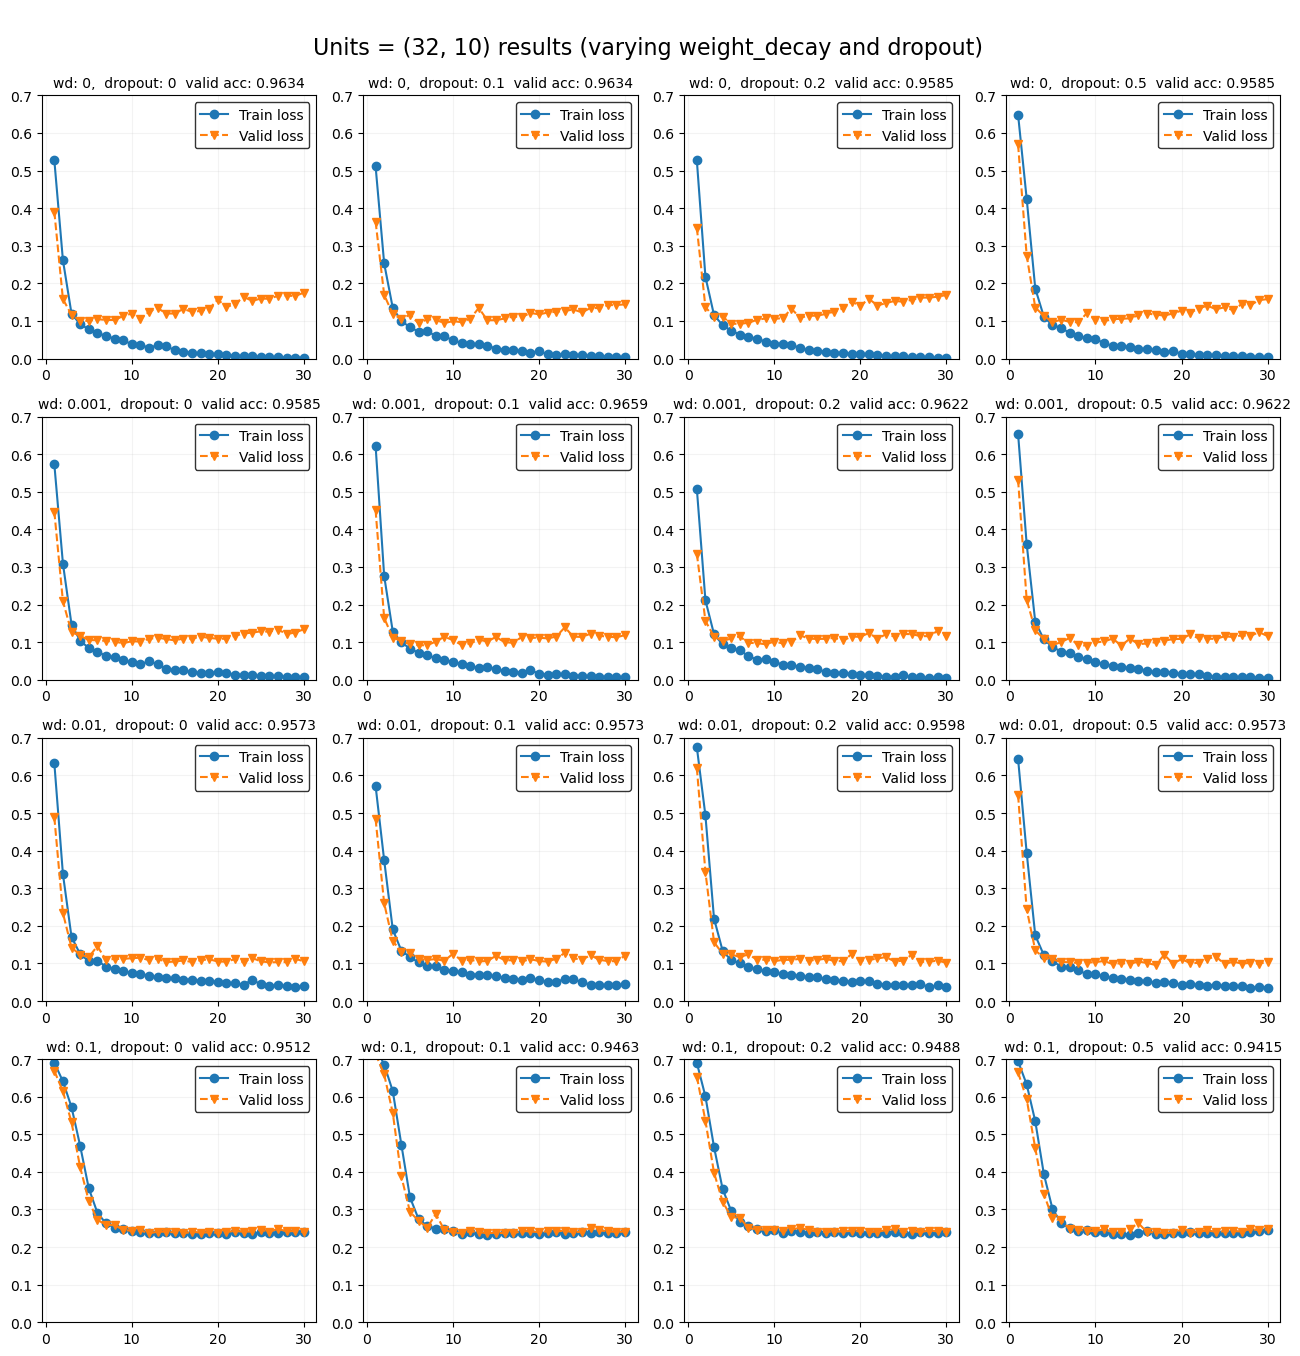

In [72]:
u = 3

fig, axs = plt.subplots(4, 4, figsize=(13, 13))

for i in range(4):
    for j in range(4):
        
        axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][0], '-o', label='Train loss')
        axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][2], '--v', label='Valid loss')
        
        #axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][1], '-o', label='Train accuracy')
        #axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][3], '-v', label='Valid accuracy')
        
        axs[i, j].set_title('wd: ' + str(tuning_results_lr0p001[u,i,j][0][1]) + ',  dropout: ' + str(tuning_results_lr0p001[u,i,j][0][2]) + '  valid acc: ' + str(round(tuning_results_lr0p001[u,i,j][1][3][-1].item(), 4)), fontsize=10)
        axs[i, j].legend(frameon=True, edgecolor='k')
        
        axs[i, j].set_ylim([0, 0.7])
        #axs[i, j].set_ylim([0.8, 1])
        
        axs[i, j].grid(alpha=0.15)

plt.tight_layout()
plt.suptitle('\n Units = (32, 10) results (varying weight_decay and dropout)', y=1.04, fontsize=16)
plt.show()

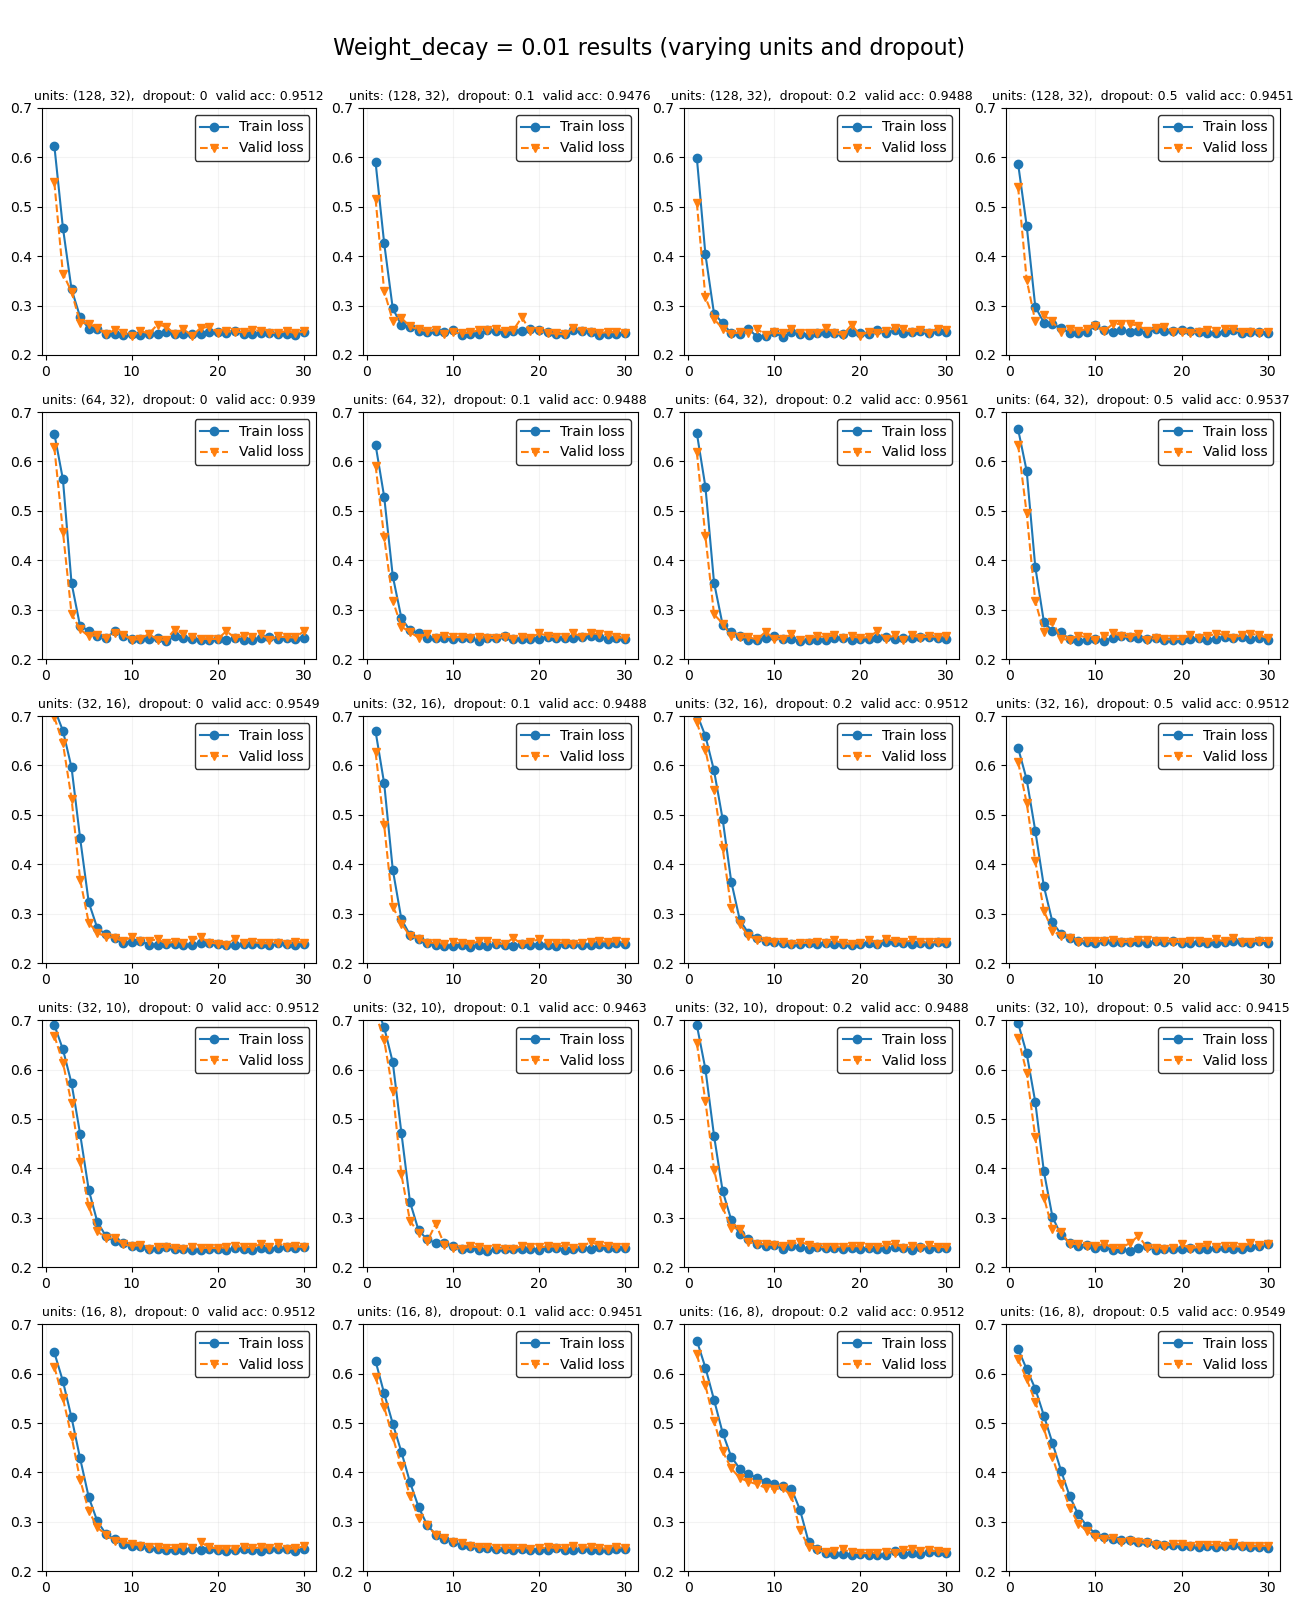

In [74]:
w = 3

fig, axs = plt.subplots(5, 4, figsize=(13, 16))

for i in range(5):
    for j in range(4):
                
        axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[i,w,j][1][0], '-o', label='Train loss')
        axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[i,w,j][1][2], '--v', label='Valid loss')
        
        #axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][1], '-o', label='Train accuracy')
        #axs[i, j].plot(np.arange(num_epochs) + 1, tuning_results_lr0p001[u,i,j][1][3], '-v', label='Valid accuracy')
        
        axs[i, j].set_title('units: ' + str(tuning_results_lr0p001[i,w,j][0][0]) + ',  dropout: ' + str(tuning_results_lr0p001[i,w,j][0][2]) + '  valid acc: ' + str(round(tuning_results_lr0p001[i,w,j][1][3][-1].item(), 4)), fontsize=9)
        axs[i, j].legend(frameon=True, edgecolor='k')
        
        axs[i, j].set_ylim([0.2, 0.7])        
        axs[i, j].grid(alpha=0.15)

plt.suptitle('\n Weight_decay = 0.01 results (varying units and dropout)', y=1, fontsize=16)
plt.tight_layout()
plt.show()

In [78]:
p = 0.2
wd = 0.1
units = (64, 32)


model_final = model = nn.Sequential(

    nn.Linear(144, units[0]),
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(units[0], units[1]),
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(units[1], 1),
    nn.Sigmoid()

)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.001, weight_decay=wd)
num_epochs = 30

hist_final = train(model_final, num_epochs, train_dl, valid_dl)

pred = model_final(X_test)[:, 0]
is_correct = ((pred >= 0.5).float() == y_test).int()
test_accuracy = (is_correct.sum() / is_correct.shape[0]).item()

print(f'\n Test set accuracy = {test_accuracy}')

Epoch 1    Train Accuracy: 0.8252   Train Loss: 0.6444     Valid Accuracy: 0.9329   Valid Loss: 0.6055
Epoch 2    Train Accuracy: 0.9240   Train Loss: 0.5473     Valid Accuracy: 0.9220   Valid Loss: 0.4765
Epoch 3    Train Accuracy: 0.9346   Train Loss: 0.3861     Valid Accuracy: 0.9427   Valid Loss: 0.3125
Epoch 4    Train Accuracy: 0.9451   Train Loss: 0.2888     Valid Accuracy: 0.9427   Valid Loss: 0.2776
Epoch 5    Train Accuracy: 0.9496   Train Loss: 0.2676     Valid Accuracy: 0.9512   Valid Loss: 0.2594
Epoch 6    Train Accuracy: 0.9524   Train Loss: 0.2518     Valid Accuracy: 0.9476   Valid Loss: 0.2494
Epoch 7    Train Accuracy: 0.9528   Train Loss: 0.2498     Valid Accuracy: 0.9488   Valid Loss: 0.2469
Epoch 8    Train Accuracy: 0.9537   Train Loss: 0.2476     Valid Accuracy: 0.9500   Valid Loss: 0.2434
Epoch 9    Train Accuracy: 0.9528   Train Loss: 0.2390     Valid Accuracy: 0.9561   Valid Loss: 0.2399
Epoch 10    Train Accuracy: 0.9516   Train Loss: 0.2409     Valid Accurac